<a href="https://colab.research.google.com/github/MedicalImageAnalysisTutorials/ImageRegistrationTutorial/blob/master/m2p_image_registration_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>**Image Registration using Mean Squared Error Metric, 2D Translation Transform, and Gradient Descent**</center>

This is a complete image registration example for beginners. It uses MSE metric, to find parameters of a 2D translation transform using gradient descent optimiser. I first provide an example using ITK tool then using a simple python implmentation.

<br/> 
This tutorial is prepared by: [Ibraheem Al-Dhamari](mailto:ibr.exg@gmail.com). 

----



#Setup:

### TODOs:


* use same paper structure:
  - same section, equations, figures, tables, variables numbers
  - we may use in-between numbering to add more  
* add missing information and implementations
* translate the math to code without using built-in functions
  - we can define our functions then we use them in other sections or papers  
  
* ibraheem: ok, please re-check the draft notebook. I added the same images and the computation from Matthew notebook and reproduced the same results. The only missing is to compute the joint-histogram instead of using numpy function histogram2d. With this, we have mutual information implementation complete and the next thing is to implement the derivative. For the derivative, we can assume a simple 2D translation transform as an example

*Hi, check the above screenshot, the updates is in the mutual information part. I also checked the links from deep learning, there is a python implementation there for mutual information and its derivative, I am trying to understand it now.

by deep learning, I meant the voxelmorhp.


## Instalaltion

 

In [ ]:

#========================================
#                  Setup
#========================================
# !pip install itk
# !pip install vtk
# !pip install SimpleITK
# !pip install Pillow
# #clone data files from github
# ! rm -r PapersExplained
# !git clone  https://github.com/MedicalImageAnalysisTutorials/PapersExplained.git

print("Python version : ")  

!python --version

# - compatibility with Python 2
from __future__ import print_function  # print('me') instead of print 'me'
from __future__ import division  # 1/2 = 0.5, not 0

# - import common modules
import os, time, random, IPython, datetime, math, itk, PIL, urllib.request

import numpy as np,  scipy.ndimage as snd, pandas as pd,SimpleITK as sitk
import plotly.offline as pyo,  plotly.graph_objs as go, cufflinks as cf
import matplotlib.pyplot as plt 
import numpy as np
import matplotlib.pyplot as plt

from sys import argv
from scipy import ndimage, misc, signal, stats
from PIL import Image, ImageDraw
from datetime import date
from plotly import __version__
from plotly.offline import iplot
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
from ipywidgets import *
from IPython.html.widgets import *
from numpy import array, linalg, matrix
# from scipy.misc import comb as nOk

 # the Python plotting package
#%matplotlib notebook
%matplotlib inline

# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

myDataPath       = "PapersExplained/Data"


Python version : 
Python 3.6.9


## Input images

An image from ITK examples is downloaded  then we create a moving image by shifting the fixed image in x and y directions

downloading data


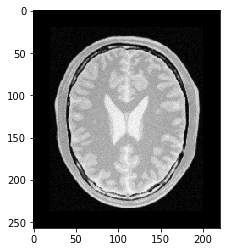

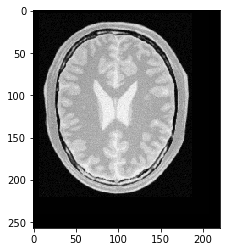

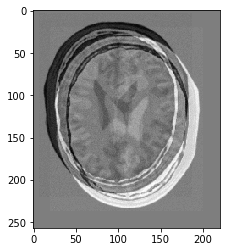

fixed image size    :  itkSize2 ([221, 257])
fixed image spacing :  itkVectorD2 ([1, 1])
fixed image origin  :  itkPointD2 ([0, 0])
moving image size    :  itkSize2 ([221, 257])
moving image spacing :  itkVectorD2 ([1, 1])
moving image origin  :  itkPointD2 ([0, 0])


In [ ]:
#---------------------------------------------------------------
# genral paramaeters:
#---------------------------------------------------------------

swImage       = 0 # switch moving and fixed
useMSE        = 1    

#Optimiser parameters
numIterations = 100  
stepSize      = -1   

# translation transform parameters 
tx  = 13; 
ty  = 17; 
mu  = [tx,ty]


#---------------------------------------------------------------
# Input data 
#---------------------------------------------------------------
print("downloading data")
fixedFilename  = "BrainProtonDensitySliceBorder20.png"
fixedLink = "https://github.com/InsightSoftwareConsortium/ITK/raw/master/Examples/Data/BrainProtonDensitySliceBorder20.png"
urllib.request.urlretrieve (fixedLink, fixedFilename)

def imTransform(imgA,tPars):
    #input image array and a transformation matrix, return transformed image array
    img = sitk.GetImageFromArray(imgA)
    origin = img.GetOrigin()
    img.SetOrigin((0,0,0))
    transform = sitk.TranslationTransform(2)
    transform.SetParameters(tPars)
    outimage=sitk.Resample(img,img.GetSize(),transform,sitk.sitkLinear,[0,0,0], img.GetSpacing(), img.GetDirection())
    outimage.SetOrigin(origin)
    resultImage = sitk.GetArrayFromImage(outimage)
    return resultImage

def getMovingImage(fixed,mu,isMSE):
    #transform     
    imgA =imTransform(itk.GetArrayFromImage(fixed),mu)
    if not isMSE:
       #invert in case of mutual information 
       imgA = np.max(imgA)-imgA 
    movingImage = itk.GetImageFromArray(imgA)
    movingImage.CopyInformation(fixed)
    return movingImage

#  Reading the image using ITK

#define data types
dimension         = 2
PixelType         = itk.F
FixedImageType    = itk.Image[PixelType, dimension]
MovingImageType   = itk.Image[PixelType, dimension]

fixedImageReader  = itk.ImageFileReader[FixedImageType].New()
fixedImageReader.SetFileName(fixedFilename);   fixedImageReader.Update()
fixedImage        = fixedImageReader.GetOutput()
fixedImageRegion  = fixedImage.GetBufferedRegion()

#generate a moving image 

# to test the effect of multi-modality we invert the color 
isSame =   useMSE 
movingImage = getMovingImage(fixedImage,mu,isSame)

u  = itk.GetArrayFromImage(fixedImage)   
v  = itk.GetArrayFromImage(movingImage) 
plt.imshow(u)
plt.show()
plt.imshow(v)
plt.show()
plt.imshow(u-v)
plt.show()

print("fixed image size    : ", fixedImage.GetLargestPossibleRegion().GetSize())
print("fixed image spacing : ", fixedImage.GetSpacing())
print("fixed image origin  : ", fixedImage.GetOrigin())

print("moving image size    : ", movingImage.GetLargestPossibleRegion().GetSize())
print("moving image spacing : ", movingImage.GetSpacing())
print("moving image origin  : ", movingImage.GetOrigin())


## Image registration

Image registtraion is the problem of finding parameters $\mu$ of a transformation $T(P,\mu)$ that aligns an image called the moving image $I_M(P)$ to another imaeg called the fixed image $I_F(P)$.

Finding these parameters is challenging. Optimisation e.g. gradient descent optimiser is used to find these parameters. The gradient descent tries to minimise a similarity metric $S(I_F,I_M)$by updating a transformation parameters.

$$\tag{1}
\mu = \mathrm{arg\,min}\quad S(I_F(P),I_M(T(P,\mu_{init}))
$$

where $\mu_{init}$ is the initial parameters.

 In this example the similarity metric is the mean squared error $S_{MSE}(I_F,I_M)$ which is defined as: 
$$\tag{2}
S_{MSE}(I_F(P),I_M(T(P,\mu)) =\frac{1}{n}\sum^{n-1}_{i=0}(I_F(p_i)-I_M(T(p_i,\mu)))^2
$$
where $n$ is the number of pixels in the image. 



The algorithm can be summarized by the following equation. Given two images $u$ and $v$ whose data is expressed as $u(x)$ and $v(y)$, find 

It means, find the transformation $T$ that maximizes the mutual information between $U$ and $V$. The algorithm goes by the name **em**pirical entropy **m**anipulation and **a**nalysis or its acronym **EMMA**.



## ITK example 

Here I am using an ITK example to align the input fixed and moving images.   

itkPointSetD3 not loaded from module ITKRegistrationCommon because of exception:
 module 'itk.ITKRegistrationCommonPython' has no attribute 'itkPointSetD3'


0 : M: 0.573381   P: 0.000000 0.000000 
1 : M: 0.571591   P: -0.015760 -0.014661 
2 : M: 0.569916   P: -0.030898 -0.028870 
3 : M: 0.568347   P: -0.045443 -0.042645 
4 : M: 0.566876   P: -0.059417 -0.056000 
5 : M: 0.565496   P: -0.072846 -0.068949 
6 : M: 0.564200   P: -0.085753 -0.081506 
7 : M: 0.562981   P: -0.098159 -0.093684 
8 : M: 0.561834   P: -0.110084 -0.105497 
9 : M: 0.560755   P: -0.121550 -0.116956 
10 : M: 0.559737   P: -0.132574 -0.128074 
11 : M: 0.558777   P: -0.143175 -0.138861 
12 : M: 0.557872   P: -0.153370 -0.149327 
13 : M: 0.557016   P: -0.163176 -0.159485 
14 : M: 0.556207   P: -0.172609 -0.169343 
15 : M: 0.555443   P: -0.181683 -0.178911 
16 : M: 0.554719   P: -0.190413 -0.188198 
17 : M: 0.554034   P: -0.198813 -0.197214 
18 : M: 0.553384   P: -0.206896 -0.205966 
19 : M: 0.552768   P: -0.214675 -0.214464 
20 : M: 0.552184   P: -0.222161 -0.222714 
21 : M: 0.551630   P: -0.229367 -0.230725 
22 : M: 0.551103   P: -0.236304 -0.238504 
23 : M: 0.550603   P: -

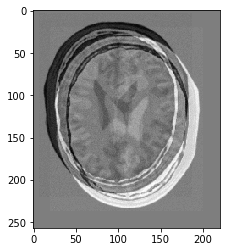

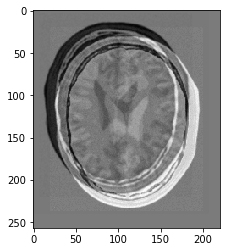

all tasks are done!.............


NameError: ignored

In [ ]:
# This is an image registration code using ITK


InternalImageType = itk.Image[itk.F, dimension]
OptimizerType        = itk.GradientDescentOptimizer
RegistrationType     = itk.ImageRegistrationMethod[InternalImageType, InternalImageType]  
InterpolatorType     = itk.LinearInterpolateImageFunction[InternalImageType, itk.D]
TransformType        = itk.TranslationTransform[itk.D, dimension]
# InitialTransformType = itk.CenteredTransformInitializer[TransformType,FixedImageType,MovingImageType]

miMetricType     = itk.MutualInformationImageToImageMetric[InternalImageType, InternalImageType]
#mseMetricType    = itk.MeanSquaresImageToImageMetricv4[InternalImageType, InternalImageType]
mseMetricType    = itk.MeanSquaresImageToImageMetric[InternalImageType, InternalImageType]

#Instantiate the classes for the registration  framework
transform    = TransformType.New()
optimizer    = OptimizerType.New()
interpolator = InterpolatorType.New()
registration = RegistrationType.New()
metric       = miMetricType.New()
# initializer = InitialTransformType.New()
#  Read the fixed and moving images using filenames
#  from the command line arguments



#preprocessing
# normalization is important  
FixedNormalizeFilterType = itk.NormalizeImageFilter[FixedImageType, InternalImageType]
MovingNormalizeFilterType = itk.NormalizeImageFilter[MovingImageType, InternalImageType]

fixedNormalizer = FixedNormalizeFilterType.New()
movingNormalizer = MovingNormalizeFilterType.New()

fixedNormalizer.SetInput(fixedImage)
movingNormalizer.SetInput(movingImage)
fixedNormalizer.Update()
fixedImageRegion = fixedNormalizer.GetOutput().GetBufferedRegion()
numberOfPixels = fixedImageRegion.GetNumberOfPixels()
numberOfSamples = int((numberOfPixels * 0.01))

# initializer.SetTransform(tranform)
# initializer.SetFixedImage(fixedImage)
# initializer.SetMovingImage(movingImage)
# initializer.GeometryOn()

if useMSE:
    metric = mseMetricType.New()
else:
    # For consistent results when regression testing.
    metric.SetFixedImageStandardDeviation (0.4)
    metric.SetMovingImageStandardDeviation(0.4)
    metric.SetNumberOfSpatialSamples(numberOfSamples)
    metric.ReinitializeSeed(121212)

# it seems smoothing is not important
# GaussianFilterType = itk.DiscreteGaussianImageFilter[InternalImageType, InternalImageType]
# fixedSmoother = GaussianFilterType.New()
# movingSmoother = GaussianFilterType.New()
# fixedSmoother.SetVariance(2.0)
# movingSmoother.SetVariance(2.0)
# fixedSmoother.SetInput(fixedNormalizer.GetOutput())
# movingSmoother.SetInput(movingNormalizer.GetOutput())

#image registration 
registration.SetOptimizer(optimizer)
registration.SetTransform(transform)
registration.SetInterpolator(interpolator)
registration.SetMetric(metric)
# registration.SetFixedImage(fixedSmoother.GetOutput())
# registration.SetMovingImage(movingSmoother.GetOutput())
registration.SetFixedImage(fixedNormalizer.GetOutput())
registration.SetMovingImage(movingNormalizer.GetOutput())

# registration.SetFixedImage(fixedImage)
# registration.SetMovingImage(movingImage)

registration.SetFixedImageRegion(fixedImageRegion)

initialParameters = transform.GetParameters()
initialParameters[0] = 0.0 # Initial offset in mm along X
initialParameters[1] = 0.0 # Initial offset in mm along Y

registration.SetInitialTransformParameters(initialParameters)


optimizer.SetLearningRate(stepSize)
optimizer.SetNumberOfIterations(numIterations)
optimizer.MaximizeOn()

# Create the Command observer and register it with the optimizer.
def iterationUpdate():
    currentParameter = registration.GetOutput().Get().GetParameters()
    print( "%d : M: %f   P: %f %f " % (optimizer.GetCurrentIteration(), optimizer.GetValue(),  currentParameter.GetElement(0), currentParameter.GetElement(1)))
observer = itk.PyCommand.New()
observer.SetCommandCallable(iterationUpdate)
optimizer.AddObserver(itk.IterationEvent(), observer)


registration.Update()
   

finalParameters = registration.GetLastTransformParameters()
TranslationAlongX = finalParameters[0]
TranslationAlongY = finalParameters[1]
numberOfIterations = optimizer.GetCurrentIteration()
bestValue = optimizer.GetValue()


# Print out results
print("Result = ")
print(" Translation X = " + str(TranslationAlongX))
print(" Translation Y = " + str(TranslationAlongY))
print(" Iterations    = " + str(numberOfIterations))
print(" Metric value  = " + str(bestValue))
print(" Numb. Samples = " + str(numberOfSamples))

ResampleFilterType = itk.ResampleImageFilter[MovingImageType, FixedImageType]

finalTransform = TransformType.New()
finalTransform.SetParameters(finalParameters)
finalTransform.SetFixedParameters(transform.GetFixedParameters())

resample = ResampleFilterType.New()
resample.SetTransform(finalTransform)
resample.SetInput(movingImage)
resample.SetDefaultPixelValue(100)
resample.SetSize(fixedImage.GetLargestPossibleRegion().GetSize())
resample.SetOutputOrigin(fixedImage.GetOrigin())
resample.SetOutputSpacing(fixedImage.GetSpacing())
resample.SetOutputDirection(fixedImage.GetDirection())

registeredImage = resample.GetOutput()
r0 = itk.GetArrayFromImage(registeredImage)


# visualize the result 
print(u.shape)
print(v.shape)
plt.imshow(u-v)
plt.show()
plt.imshow(u-r0)
plt.show()

# tx = TranslationAlongX; ty = TranslationAlongY
# r1 = imTransform( v , [tx,ty])
# plt.imshow(u-r1)
# plt.show()
# #u_normed = ( u - np.mean(u) ) /  np.std(u)

print("all tasks are done!.............")
print(ok)

In [ ]:

def mseMetric(u,v):
    mbMSE  = 0.0
    n = u.shape[0] 
    mbMSE=np.sum([pow(x-y,2) for x,y in zip(u,v) ]) / n
    return mbMSE
def imGradient(img):
    f = itk.GetImageFromArray(img)
    df = itk.gradient_image_filter(f)
    g = itk.GetArrayFromImage(df)        
    return g

def mbdMSE(u,v,dT):
    mbMSE  = 0.0
    n = u.shape[0]*u.shape[1] 
    #dM   =  d M(y)/ dy    # gradient of the transformed moving image
    #dT   =  D T(x,p) / dp # gradient of the transformation 
    dM = imGradient(v)
    # print("dM.shape : ", dM.shape)
    # plt.imshow(dM[:,:,0])
    # plt.show()
    # plt.imshow(dM[:,:,1])
    # plt.show()
    #print("dM.shape : ", dM.shape)
    dmse = (2/n) * np.sum([pow(x-y,2) for x,y in zip(u,v) ]) 
    #print("dmse : ", dmse)
    dMdT = [0,0]
    for i in range(dM.shape[0]):
        for j in range(dM.shape[1]):
            dx = dM[i,j,0]
            dy = dM[i,j,1]
            dxy0 = np.dot([dx,dy],dT[:,0]) 
            dxy1 = np.dot([dx,dy],dT[:,1]) 
            # print("dxy0 : ", dxy0) 
            # print("dxy1 : ", dxy1) 
            dMdT[0] = dMdT[0] + dxy0
            dMdT[1] = dMdT[1] + dxy1
            # print("dMdT0 : ", dMdT[0]) 
            # print("dMdT1 : ", dMdT[1]) 
    dMSE = [dmse * dMdT[0],dmse * dMdT[1]]
    # print("dMSE : ",  dMSE)
    # print(ok)
    return     dMSE  # this should be a vector of length d dimension


#print("mse = ",mseMetric(u,u))    

# image registration using gradient descent
def gdOptimiser(u,v,numIterations,stepSize):
    nMu = [0,0]
    dT = np.array([[1,0],[0,1]])
    for i in range(numIterations):
        v_t = imTransform(v,nMu)
        mv = mseMetric(u,v_t)
        dS = mbdMSE(u,v_t,dT)
        nMu = np.array(nMu) - ( stepSize * np.array(dS) )
        print(i,": ",mv," , ", nMu)
    return nMu
#normalize
un = ( u - np.mean(u) ) /  np.std(u)
vn = ( v - np.mean(v) ) /  np.std(v)
print("numIterations : ", numIterations)
print("stepSize      : ", stepSize)

plt.imshow(un)
plt.show()
plt.imshow(vn)
plt.show()
plt.imshow(un-vn)
plt.show()
mu =  gdOptimiser(un,vn,100,1)

In [ ]:
#important preprocessing steps: 
# normalize + smoothing 

# fig = plt.figure(figsize=(10, 5))
# plt.imshow(np.hstack((u, v)))

print("input images u and v sizes: ",u.shape,v.shape)

#N_A = np.prod(u.shape) // 2
N_A = np.prod(u.shape) 

print("number of samples N_A     :  ",N_A)

# Choose a random sample from u and v. Here we selected 50% of the image data.
idx_U = np.random.choice(np.prod(u.shape),    size = N_A)
U_A = u.reshape(np.prod(u.shape))[idx_U]

idx_V = np.random.choice(np.prod(v.shape),  size = N_A)
V_A = v.reshape(np.prod(v.shape))[idx_V]

# Estimate the density.
# kde_u  = stats.gaussian_kde(U_A.reshape(np.prod(U_A.shape)))
# kde_v  = stats.gaussian_kde(V_A.reshape(np.prod(V_A.shape)))
kde_u  = stats.gaussian_kde(U_A.reshape(np.prod(U_A.shape)))
kde_v  = stats.gaussian_kde(V_A.reshape(np.prod(V_A.shape)))

# Plot the two densities.
least = min(np.min(U_A), np.min(V_A))
most  = max(np.max(U_A), np.max(V_A))
x = np.linspace(least, most, num = 100)

fig = plt.figure(figsize=(10, 5))
plt.plot(x, kde_u(x), label = 'Image U')
plt.plot(x, kde_v(x), label = 'Image V')
plt.title('Densities of U and V images')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10, 5))
plt.imshow(np.hstack((u, v)))


In [ ]:
# Choose another sample of the data.
# Choose a random sample from U and V. It is 1/3rd of the image data.
N_B = np.prod(U.shape) // 3

idx_U = np.random.choice(np.prod(U.shape), size = N_B)
U_B = U.reshape(np.prod(U.shape))[idx_U]

idx_V = np.random.choice(np.prod(V.shape), size = N_B)
V_B = V.reshape(np.prod(V.shape))[idx_V]

x_U = np.arange(np.min(U_B), np.max(U_B), N_B)
x_V = np.arange(np.min(V_B), np.max(V_B), N_B)

p_U = kde_u(x_U)
p_V = kde_v(x_V)

h_U = -np.log(p_U)/N_B
h_V = -np.log(p_V)/N_B

print(f'Entropy of image U is {h_U}.')
print(f'Entropy of image V is {h_V}.')


In [ ]:
# define paths 
# fixedPath  = os.path.join(myDataPath,"fixeds.png")              
# FixedImageType   = itk.Image[itk.F, 2]
        
# fixedImageReader  = itk.ImageFileReader[FixedImageType].New()
# fixedImageReader.SetFileName(  fixedPath)
# fixedImageReader.Update()
# fixedImage  = fixedImageReader.GetOutput()
# f0 = itk.GetArrayFromImage(fixedImage)      
# f0 = np.array(Image.fromarray(f0).resize(size=(30, 30)))
# mbImShow(f0,'Original image')      
        
# # create a new moving image by shifting the fixed image 6x,10y  
# #  Define transform
# translationTtransform    = itk.TranslationTransform[itk.D, 2].New()
# tx = 2 ; ty = 2

#trying to get a moving image by translation of the array
# print(f0.shape)
# after transformation, some pixels will be out side the current image
# we extend the image by (100,100) before transformation
# expX =100 ; expY = 100
# m0 =np.zeros((f0.shape[0]+expX,f0.shape[1]+expY))
#        print(m0.shape)
        # put the source image in the middle of the extended image
        #m0[50:200,50:200]=f0
        #m0[int(expX/2):f0.shape[0]+int(expX/2)  , int(expY/2):f0.shape[1]+int(expY/2)] =f0
        #translate the image tx,ty
# m0[50-tx:80-tx , 50-ty:80-ty] = f0
#         #m0[int(expX/2)-tx:f0.shape[0]+int(expX/2)-tx,int(expY/2)-ty:f0.shape[1]+int(expY/2)-ty]=f0
#         # remove the padding
# m0 =m0[50:80,50:80]
#         #m0 = m0[int(expX/2)-tx:f0.shape[0]+int(expX/2)-tx,int(expY/2)-ty:f0.shape[1]+int(expY/2)-ty]
# movingImage = itk.GetImageFromArray(m0.astype(np.uint8))

# mbImShow(m0,'Moving image')  
        
# U = f0
# V = m0

# # Reshaped U and V
# u = U.reshape(np.prod(U.shape))
# v = V.reshape(np.prod(V.shape))


#%%
# # Reshape it.
print(np.prod(U.shape))
u = U.reshape(np.prod(U.shape))
v=V.reshape(np.prod(V.shape))

gradu2=np.gradient(u)
#    print(u[0:10])
#    print(np.shape(u))


#variance of V
# assume covariance of v according to the thesis they suggest to estimate psi_inv_v too
# for the sake of simplicity. I have assumed some value here. 
psi_inv_v = 1/4000.
psi_inv_u = 1/4000.

w         = np.vstack((u,v))
psi_inv_w = np.array([[psi_inv_u,0],[0,psi_inv_v]])

print(np.shape(w))

Now we will see the $x$ and $y$ translate with a affine transformation operator $T$.

In [ ]:
# what is this ???

#%% transformation 

# x1=np.linspace(0,len(U[0,:])-1,len(U[0,:]),dtype='float64')
# x2=np.linspace(0,len(U[1,:])-1,len(U[1,:]),dtype='float64')
# x3=np.ones(len(U[0,:]),dtype='float64') # z dimension
# x=np.vstack((x1,x2,x3))

# # Transformation matrix is an affine transformtation
# # T1=[a1,0,b1]; T2=[a2,0,b2]; T3=[0,0,1] 3x3 matrix
# # Let us assume a simple matrix of the form

# T=np.eye(3)
# T1=T[0,:].reshape((1,3)) ;T1[0,2]=-1.5
# T2=T[1,:].reshape((1,3)) ;T2[0,2]=-1.5
# T3=T[2,:].reshape((1,3))
# y1=T1@x;y2=T2@x;y3=T3@x


In [ ]:
#%%

def gaussian_den(z, psi_inv):
  # n and d stand for the numerator and the denominator.
  if isinstance(np.float16(z), np.floating): # for scalar
      n = np.exp(-0.5 *(psi_inv*z**2))            
      d = 2 * math.pi * math.sqrt(psi_inv)
  else:                
      z=z.reshape((len(z),1)) # for vector
      n = np.exp(-0.5 * np.dot(np.matmul(z.T, psi_inv), z))
      det_psi = np.linalg.det(psi_inv)
      d = 2 * math.pi * math.sqrt(det_psi)
  return(n/d)


def weightfuncF(zi,zj,psi_inv):
    Na=len(zi)
    Nb=len(zj)
    print("Na : ",Na)
    print("Nb : ",Nb)

    W=np.zeros((Na,Nb))
    W[i,j]=gaussian_den((zi[i]-zj[j]),psi_inv)
    for i in range(Na):
        for j in range(Nb):
            W[i,j]=gaussian_den((zi[i]-zj[j]),psi_inv)
        W1=W[i,:]
        W[i,:]=W1/W1.sum()
        # print(W1.sum())
    # W=W/W.sum()
    # print(W.sum())
    return(W)

def weightfunc(zi,zj,psi_inv):
    Na=len(zi)
    Nb=len(zj)
    print("Na : ",Na)
    print("Nb : ",Nb)

    W=np.zeros((Na,Nb))
    for i in range(Na):
        for j in range(Nb):
            W[i,j]=gaussian_den((zi[i]-zj[j]),psi_inv)
        W1=W[i,:]
        W[i,:]=W1/W1.sum()
        # print(W1.sum())
    # W=W/W.sum()
    # print(W.sum())
    return(W)

def weightfunc2d(zi,zj,psi_inv):
    Na=len(zi[0,:])
    Nb=len(zj[0,:])

    print("Na : ",Na)
    print("Nb : ",Nb)

    W=np.zeros((Na,Nb))
    for i in range(Na):
        for j in range(Nb):
            W[i,j]=gaussian_den((zi[:,i]-zj[:,j]),psi_inv)
        W1=W[i,:]
        W[i,:]=W1/W1.sum()
        # print(W1.sum())
    # W=W/W.sum()
    # print(W.sum())
    return(W)

print("v.shape         : ",  v.shape)
print("psi_inv_v : ",  psi_inv_v)
print("w.shape         : ",  w.shape)
print("psi_inv_w.shape : ",  psi_inv_w.shape)

Wv = weightfunc  (v , v , psi_inv_v)
print("Wv.shape : ",  Wv.shape)
Ww = weightfunc2d(w , w , psi_inv_w)
print("Ww.shape : ",  Ww.shape)


Finding the derivative of $v$ with respect to the transformation $T$. The derivative of $v$ with respect to the transformation can be given by the chain rule of differentiation. 
$\frac{dv}{dT}=\frac{dv}{dy}\frac{dy}{dT}$.
Now $\frac{dv}{dy}$ is essentially the Jacobian of the image w.r.t. to its intensities given by  $\nabla v(y)$  . Further, as $y=T(x)$, thus, for a simple linear transformation $y=Tx$ where $T=I$, an identity matrix, we have $\frac{dv}{dT}=x$. Thus, the expression for the derivative of the transformation is then,
$\frac{dv}{dT}=\nabla v(y)x^*$, where * denotes the transpose. This expression in Einstein notation is:
$\frac{dv}{dT}=\nabla v(T(x_i))x_i^*$


In [ ]:
def derimututal(v,w,psi_inv_v,gradv,typ,x1,x2):
    size=3
    dIdT=np.zeros(size)
    if typ=='1': ## for T1
        gradv=gradv[0].flatten()
    else: # for T2
        gradv=gradv[1].flatten()
    for i in range(len(v)):
        col = i%len(x1)
        row = i//len(x1)
        xi=np.array([x1[col],x2[row],1])
        # xi=1
        for j in range(len(v)):
            col = j%len(x1)
            row = j//len(x1)
            xj=np.array([x1[col],x2[row],1])
            # xj=1
            temp=(v[i]-v[j])*(Wv[i,j]-Ww[i,j])*psi_inv_v
            # grad subtraction
            ti=gradv[i]*xi;tj=gradv[j]*xj
            dIdT=dIdT+temp*(ti-tj)
    dIdT=dIdT/len(v)
    return(dIdT.reshape((1,size)))

# loop for gradient descent. 
lamb=+0.02
print(np.shape(T1))
# loop for T1
for i in range(200):
    gradv=np.gradient(V,y1[0,:],y2[0,:])
    dIdT1=derimututal(v, w, psi_inv_v, gradv,'1',x1,x2)
    # print(dIdT1)
    T1=T1+lamb*dIdT1
    print(T1)
    y1=T1@x
    dIdT2=derimututal(v, w, psi_inv_v, gradv, '2',x1,x2)
    # print(dIdT2)
    T2=T2+lamb*dIdT2
    y2=T2@x
    print(T2)    

Please note that the above implementation seems to work for an equation like the heat equation but not for the above example. The derivative and remaining stuff work according to the math and equations explained in the paper. I think the implementation is difficult to explain in detail, but I can still try and elaborate further. But yes, I honestly feel that this paper and the algorithm is not very easy and it takes a lot of time for implementation. I have asked around students working on this and took a bit of help from them, and it seems that this implementation is a job for full blown bachelor's thesis. Because there are still certain elements missing or excluded for the ease of it. 
The bottlenecks in my opinion according to all the math are:
1. Transformation: Well, I used the same transformation you used in the start of the paper. And that, is a bit of cut-paste according to me. Any transformation as you mentioned, $(x,y)=(x+tx,y+ty)$ it's not clearly seen from your implementaion. Because, you then extend it and cut it further. So, let's say a point, $x_1,y_1$ which was there initially in $u$, is no more $x_1+tx$ and $y_+ty$, it is infact, $a*x_1+b*y_1+c$. You can verify by taking any point in the discription. According to the paper and this [link](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.8.7452&rep=rep1&type=pdf) you can see that they use affine transformations. SO, to create $V$, we should infact use affine transformation and then the algorithm would work.
2. Covariance estimation: the thesis and paper presses a lot on this. It also requires elaborate understanding and experimentation. For now, I have just assumed some value which I deemed realistic. So, even if we fix the transformation part, the covariance estimation part will still remain. And in my experience on work on Kalman filters, this is not an easy task that you can show with tutorial. So, I feel that if we already knew the covariance of the problem at hand then a tutorial like this would be easier to show. 

In [ ]:
# ITK implementation
print("ITK implementation")
def mbRandomSamples(X,n)
    y = 0;
    # get random samples od length n
    return y
def MIgrad(U,V,T)
    #get A, B randome samples
    N_A = int(0.5 * U.shape[0])
    N_B = int(0.5 * V.shape[0])
    A = mbRandomSamples(U,N_A) 
    B = mbRandomSamples(V,N_B) 
    for i in range(N_B)
        for j in range (N_A)
            # compute dv^T = [vi - vj]^T
            # compute Wv
            # compute Wuv
            # compute psi(v)
            # compute psi(vv)

            # W= W1 * Psi(v)^-1 - W2 * Psi(vv)^-1 
            # compute ddv/dT
            # dMI = dv^T*W*ddv